In [20]:
# STEP 1: Import package code
%matplotlib inline
import matplotlib
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import plantcv as pcv

In [21]:
# STEP 2: Set global variables
matplotlib.rcParams["figure.figsize"] = [8, 8]
device = 0                                   # Workflow step counter
debug = 'plot'                               # Plot debug images to the notebook
rgb_img = '2016-09-27_1025_ch129-pos01.jpg'  # Image filename

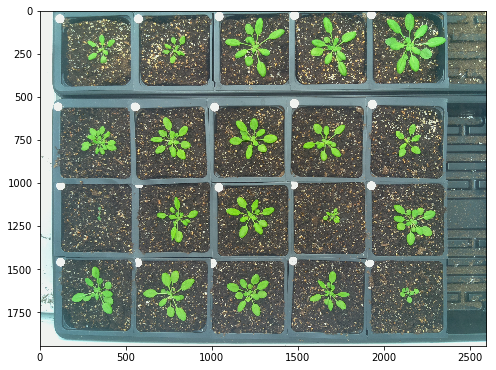

In [22]:
# STEP 3: Read RGB image and plot it to the notebook
# Inputs:
#    filename = name of image file
#    debug    = None, print (to file), or plot (to notebook)
img, path, filename = pcv.readimage(filename=rgb_img, debug=debug)

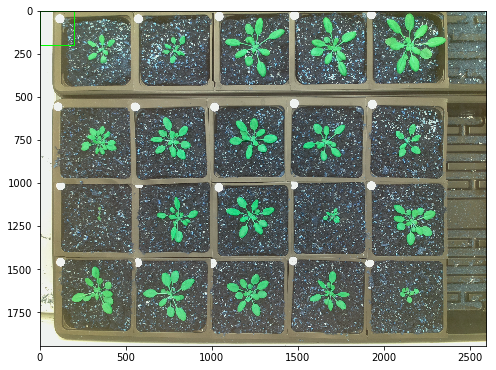

In [23]:
# Step 4: Normalize the white color so you can later
# compare color between images.
# Inputs:
#     device = device number. Used to count steps in the workflow
#     img    = image object, RGB colorspace
#     debug  = None, print, or plot. Print = save to file, Plot = print to screen.
#     roi    = region for white reference, if none uses the whole image,
#              otherwise (x position, y position, box width, box height)

# white balance image based on white toughspot
device, img1 = pcv.white_balance(device=device, img=img, debug=debug, roi=(0, 0, 200, 200))

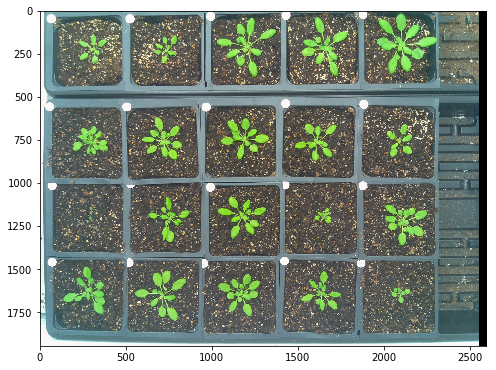

In [24]:
# Step 5: Shift image. This step is important for clustering later on.
# For this image it also allows you to push the green raspberry pi camera
# out of the image. This step might not be necessary for all images.
# The resulting image is the same size as the original.
# Input:
#     img    = image object
#     device = device number. Used to count steps in the workflow
#     number = integer, number of pixels to move image
#     side   = direction to move from "top", "bottom", "right","left"
#     debug  = None, print, or plot. Print = save to file, Plot = print to screen.

device, shift1 = pcv.shift_img(img=img1, device=device, number=50, side='right', debug=debug)
img1 = shift1

In [25]:
# STEP 6: Convert image from RGB colorspace to LAB colorspace
# Keep only the green-magenta channel (grayscale)
# Inputs:
#    img     = image object, RGB colorspace
#    channel = color subchannel (l = lightness, a = green-magenta , b = blue-yellow)
#    device  = device number. Used to count steps in the workflow
#    debug   = None, print, or plot. Print = save to file, Plot = print to screen.
device, a = pcv.rgb2gray_lab(img=img1, channel='a', device=device, debug=debug)

In [26]:
# STEP 7: Set a binary threshold on the Saturation channel image
# Inputs:
#    img         = img object, grayscale
#    threshold   = threshold value (0-255)
#    maxValue    = value to apply above threshold (usually 255 = white)
#    object_type = light or dark
#                  - If object is light then standard thresholding is done
#                  - If object is dark then inverse thresholding is done
#    device      = device number. Used to count steps in the pipeline
#    debug       = None, print, or plot. Print = save to file, Plot = print to screen.
device, img_binary = pcv.binary_threshold(img=a, threshold=110, maxValue=255, object_type='dark', 
                                          device=device, debug=debug)

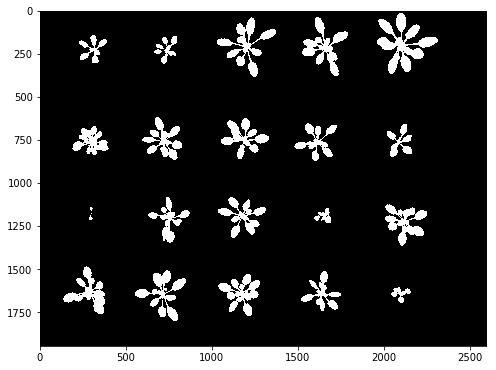

In [27]:
# STEP 8: Fill in small objects (speckles)
# Inputs:
#    img    = image object, grayscale. img will be returned after filling
#    mask   = image object, grayscale. This image will be used to identify contours
#    size   = minimum object area size in pixels (integer)
#    device = device number. Used to count steps in the pipeline
#    debug  = None, print, or plot. Print = save to file, Plot = print to screen.
mask = np.copy(img_binary)
device, fill_image = pcv.fill(img=img_binary, mask=mask, size=50, device=device, debug=debug)

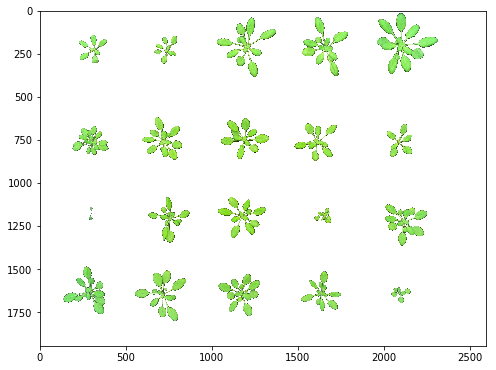

In [28]:
# STEP 9: Apply binary mask to the RGB image
# Inputs:
#    img        = image object, RGB
#    mask       = image object, grayscale. Used to mask the input image
#    mask_color = masked image background color (white or black)
#    device     = device number. Used to count steps in the pipeline
#    debug      = None, print, or plot. Print = save to file, Plot = print to screen.
device, masked = pcv.apply_mask(img=img1, mask=fill_image, mask_color='white', device=device, debug=debug)

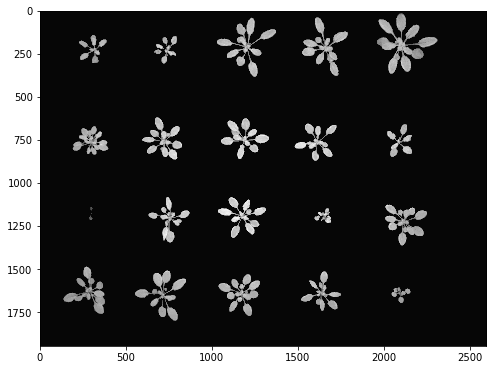

In [29]:
# STEP 10: Convert masked image to LAB colorspace and keep the blue-yellow channel
# Inputs:
#    img     = image object, RGB
#    channel = LAB color channel to return (l = lightness, a = green-magenta, b = blue-yellow)
#    device  = device number. Used to count steps in the pipeline
#    debug   = None, print, or plot. Print = save to file, Plot = print to screen.
device, b = pcv.rgb2gray_lab(img=masked, channel='b', device=device, debug=debug)

In [30]:
# STEP 11: Set a binary threshold on the Saturation channel image
# Inputs:
#    img         = img object, grayscale
#    threshold   = threshold value (0-255)
#    maxValue    = value to apply above threshold (usually 255 = white)
#    object_type = light or dark
#                  - If object is light then standard thresholding is done
#                  - If object is dark then inverse thresholding is done
#    device      = device number. Used to count steps in the pipeline
#    debug       = None, print, or plot. Print = save to file, Plot = print to screen.
device, masked_binary = pcv.binary_threshold(img=b, threshold=140, maxValue=255, object_type='light', 
                                             device=device, debug=debug)

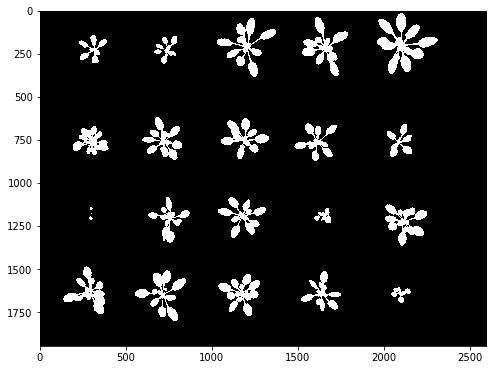

In [31]:
# STEP 12: Fill in small objects (speckles)
# Inputs:
#    img    = image object, grayscale. img will be returned after filling
#    mask   = image object, grayscale. This image will be used to identify contours
#    size   = minimum object area size in pixels (integer)
#    device = device number. Used to count steps in the pipeline
#    debug  = None, print, or plot. Print = save to file, Plot = print to screen.
mask2 = np.copy(masked_binary)
device, fill_image1 = pcv.fill(img=masked_binary, mask=mask2, size=100, device=device, debug=debug)

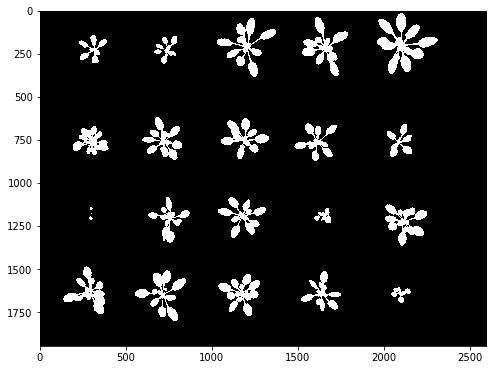

In [32]:
# STEP 13: Dilate so that you don't lose leaves (just in case)
# Inputs:
#    img     = input image
#    kernel  = integer
#    i       = interations, i.e. number of consecutive filtering passes
#    device  = device number. Used to count steps in the pipeline
#    debug   = None, print, or plot. Print = save to file, Plot = print to screen.
device, dilated = pcv.dilate(img=fill_image1, kernel=1, i=1, device=device, debug=debug)

In [33]:
# STEP 14: Find objects (contours: black-white boundaries)
# Inputs:
#    img       = image that the objects will be overlayed
#    mask      = what is used for object detection
#    device    = device number.  Used to count steps in the pipeline
#    debug     = None, print, or plot. Print = save to file, Plot = print to screen.
device, id_objects, obj_hierarchy = pcv.find_objects(img=img1, mask=dilated, device=device, debug=debug)

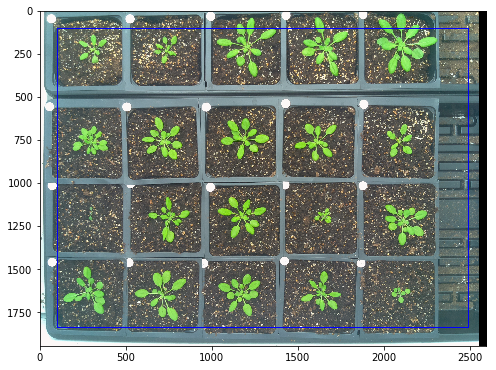

In [34]:
# STEP 15: Define region of interest (ROI)
# Inputs:
#    img       = img to overlay roi
#    roi       = default (None) or user input ROI image, object area should be white and background should be black,
#                has not been optimized for more than one ROI
#    roi_input = type of file roi_base is, either 'binary', 'rgb', or 'default' (no ROI inputted)
#    shape     = desired shape of final roi, either 'rectangle' or 'circle', if  user inputs rectangular roi but chooses
#                'circle' for shape then a circle is fitted around rectangular roi (and vice versa)
#    device    = device number.  Used to count steps in the pipeline
#    debug     = None, print, or plot. Print = save to file, Plot = print to screen.
#    adjust    = either 'True' or 'False', if 'True' allows user to adjust ROI
#    x_adj     = adjust center along x axis
#    y_adj     = adjust center along y axis
#    w_adj     = adjust width
#    h_adj     = adjust height
device, roi, roi_hierarchy = pcv.define_roi(img=img1, shape='rectangle', device=device, roi=None, roi_input='default',
                                            debug=debug, adjust=True, x_adj=100, y_adj=100, w_adj=-100, h_adj=-100)

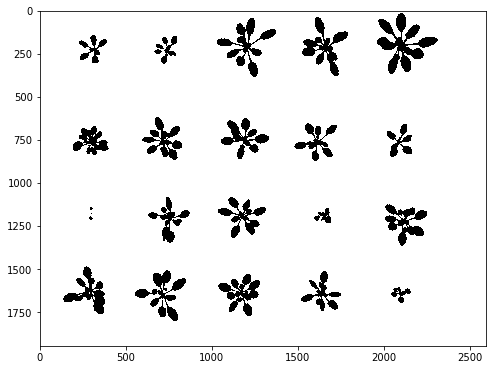

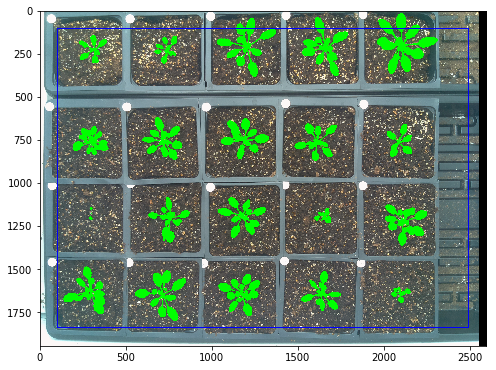

In [35]:
# STEP 16: Keep objects that overlap with the ROI
# Inputs:
#    img            = img to display kept objects
#    roi_type       = 'cutto' or 'partial' (for partially inside)
#    roi_contour    = contour of roi, output from "View and Ajust ROI" function
#    roi_hierarchy  = contour of roi, output from "View and Ajust ROI" function
#    object_contour = contours of objects, output from "Identifying Objects" fuction
#    obj_hierarchy  = hierarchy of objects, output from "Identifying Objects" fuction
#    device         = device number.  Used to count steps in the pipeline
#    debug          = None, print, or plot. Print = save to file, Plot = print to screen.
device, roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img1, roi_type='partial', 
                                                                              roi_contour=roi, 
                                                                              roi_hierarchy=roi_hierarchy, 
                                                                              object_contour=id_objects, 
                                                                              obj_hierarchy=obj_hierarchy, 
                                                                              device=device, debug=debug)


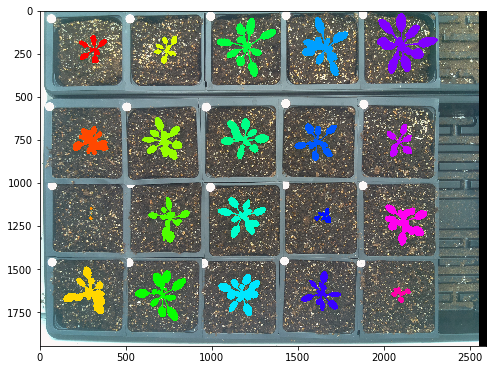

In [36]:
# Step 17: This function take a image with multiple contours and 
# clusters them based on user input of rows and columns

# Inputs:
#    device      = device number.  Used to count steps in the pipeline
#    img         = An RGB image array
#    roi_objects = object contours in an image that are needed to be clustered.
#    nrow        = number of rows to cluster (this should be the approximate  number of desired rows in the 
#                  entire image (even if there isn't a literal row of plants)
#    ncol        = number of columns to cluster (this should be the approximate number of desired columns in the 
#                  entire image (even if there isn't a literal row of plants)
#    file        = output of filename from read_image function
#    filenames   = input txt file with list of filenames in order from top to bottom left to right
#    debug       = None, print, or plot. Print = save to file, Plot = print to screen.
device, clusters_i, contours = pcv.cluster_contours(device=device, img=img1, roi_objects=roi_objects, nrow=4, ncol=6,
                                                    debug=debug)
# This is Figure 2 (top panel)

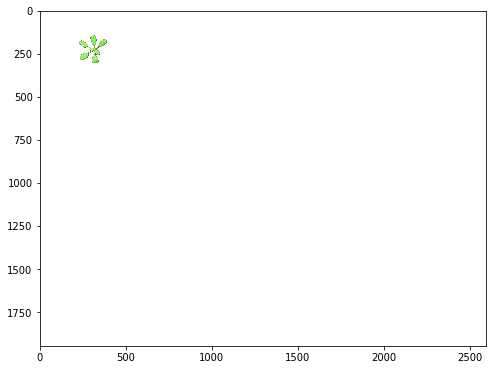

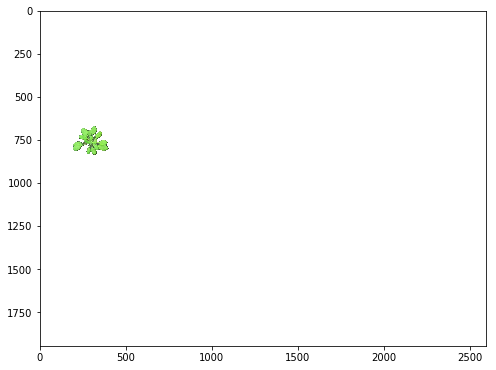

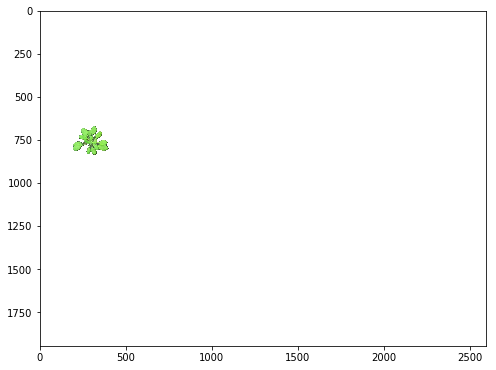

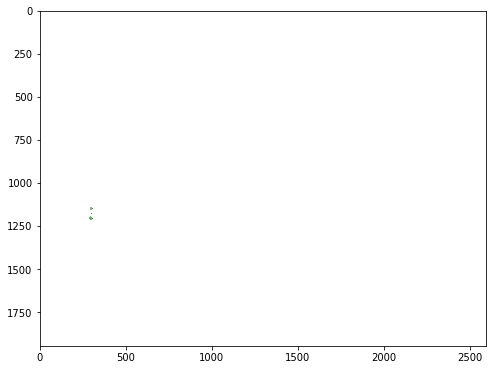

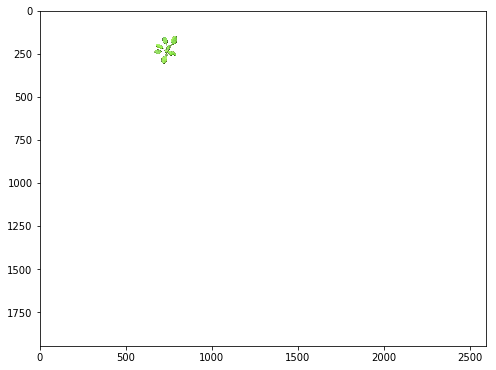

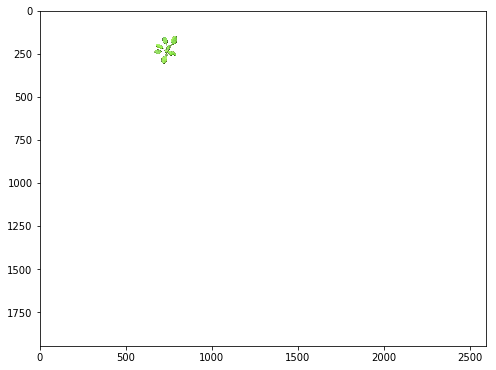

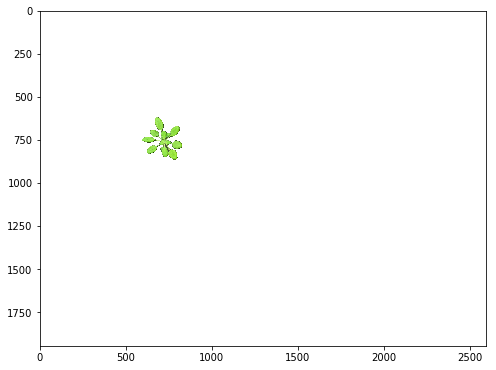

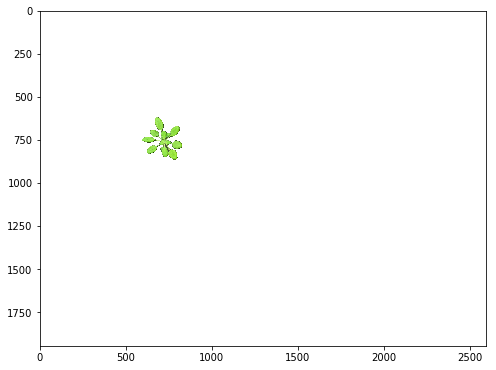

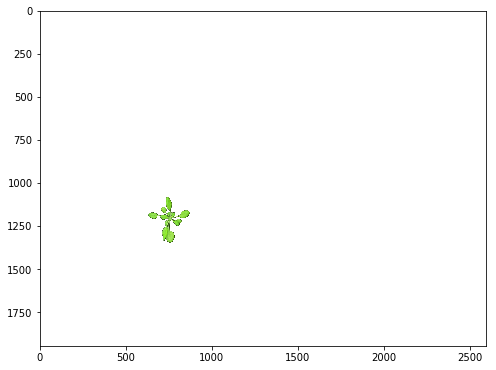

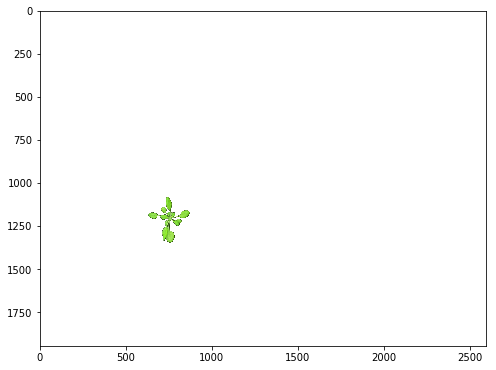

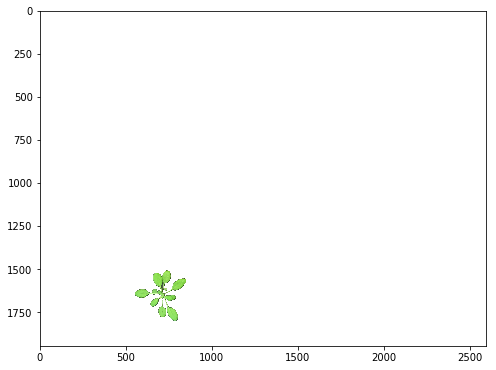

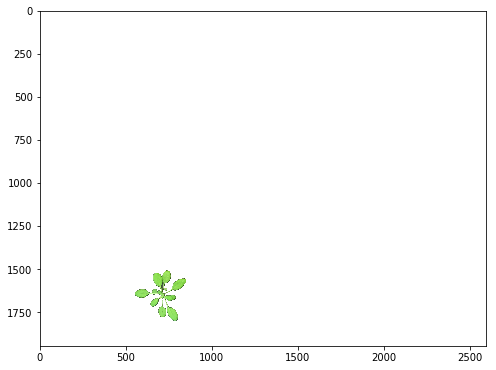

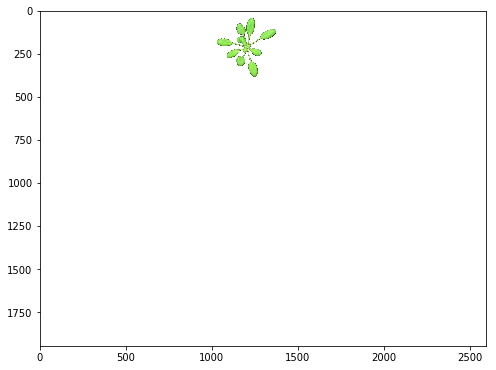

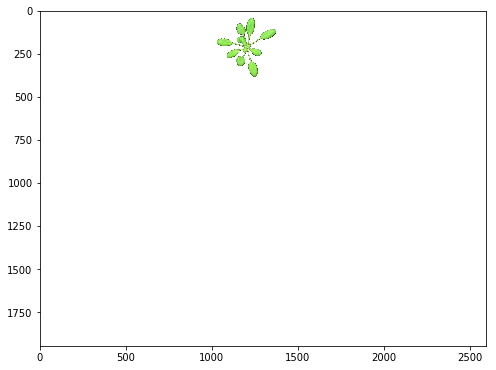

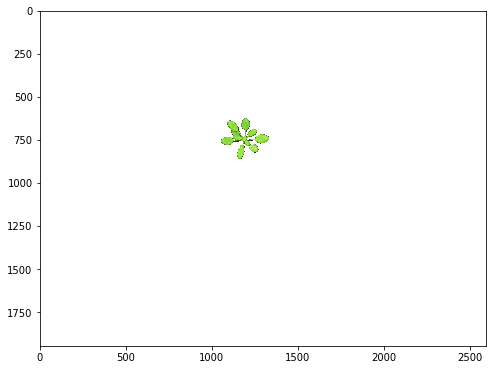

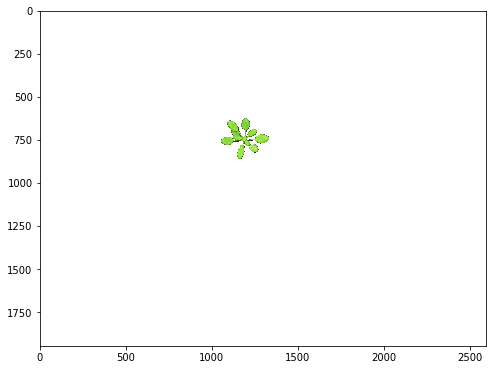

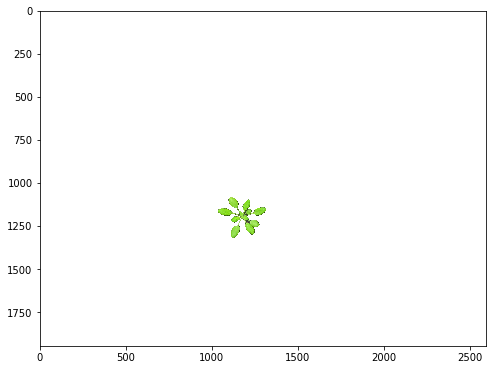

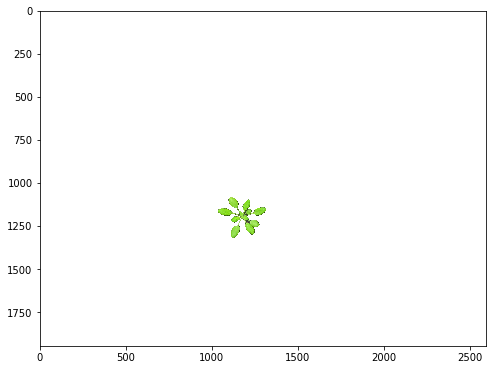

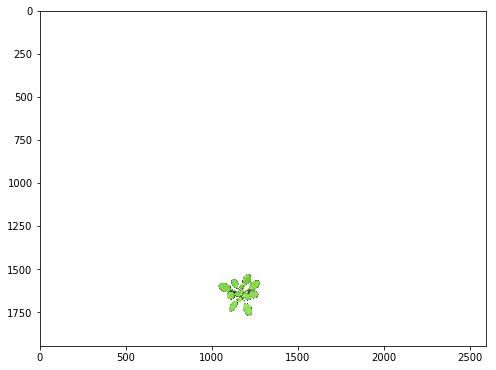

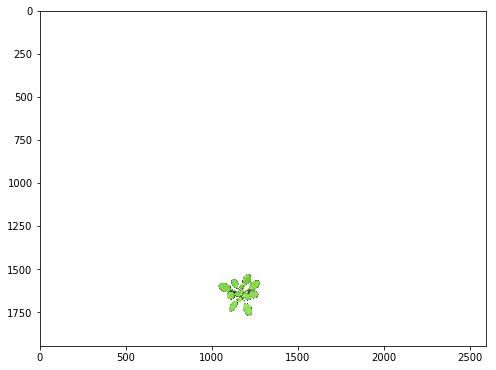

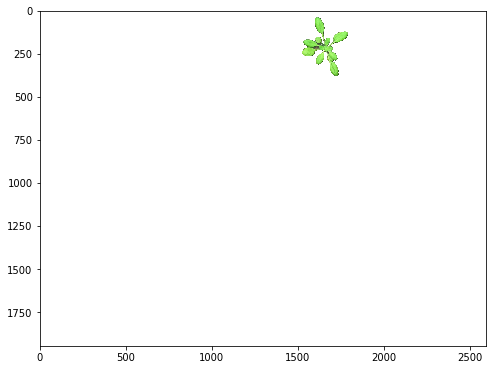

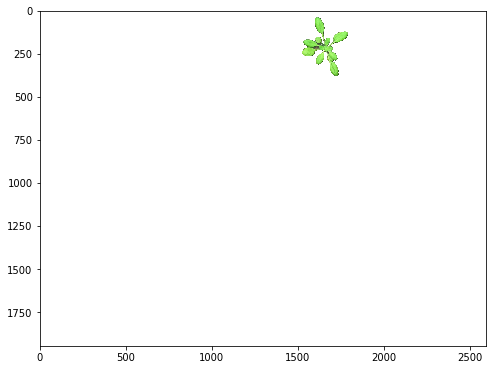

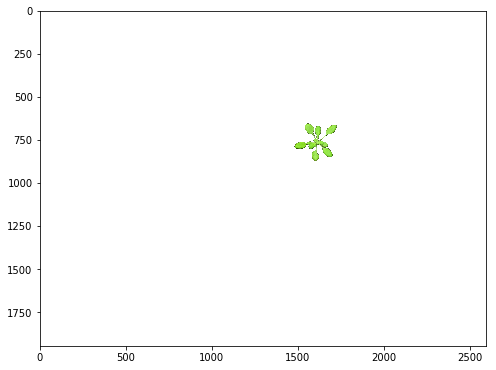

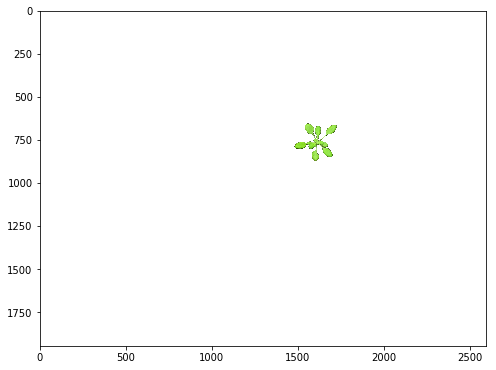

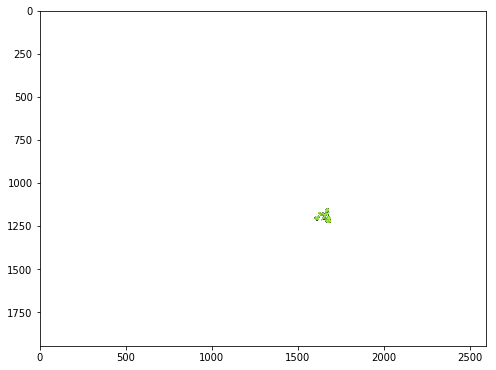

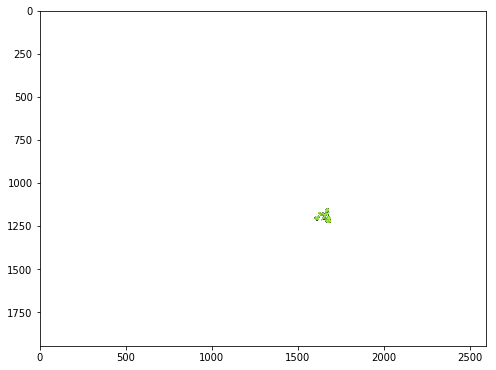

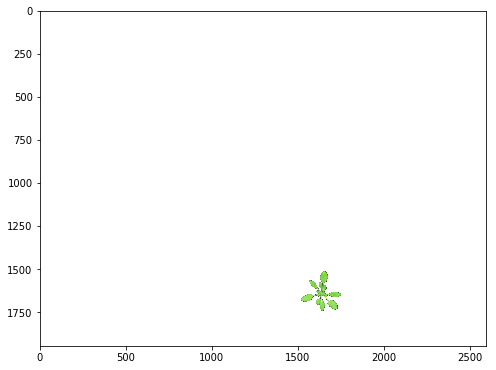

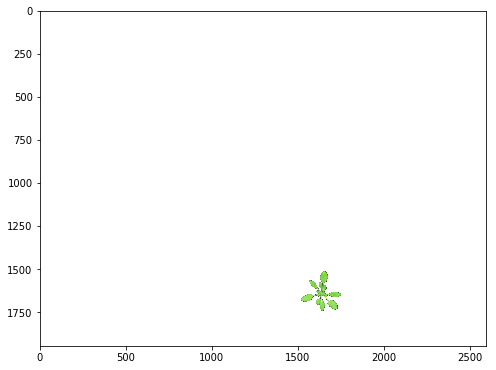

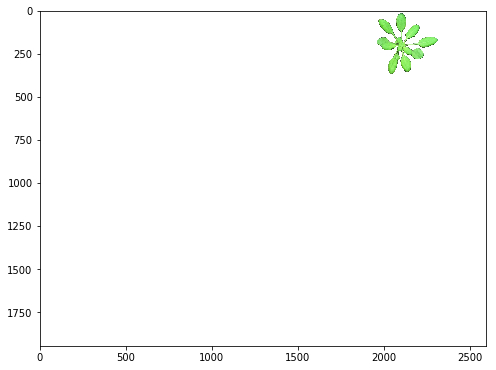

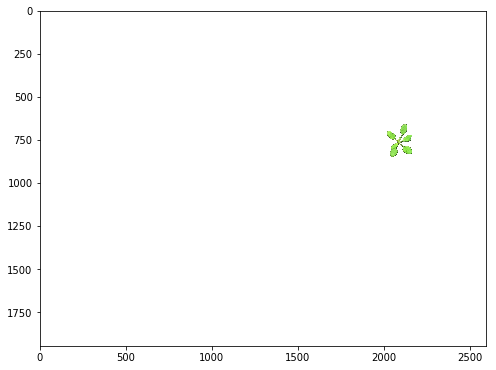

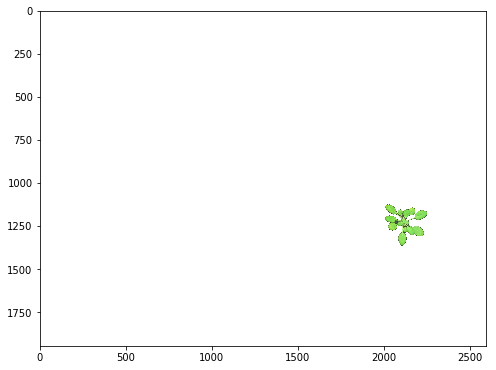

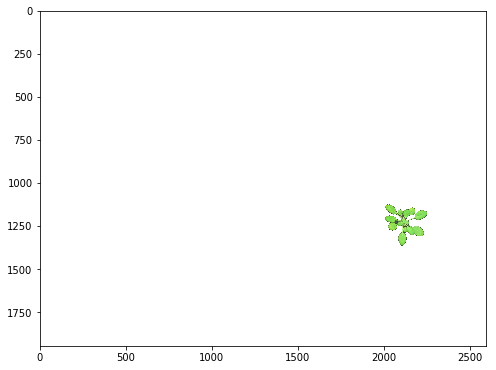

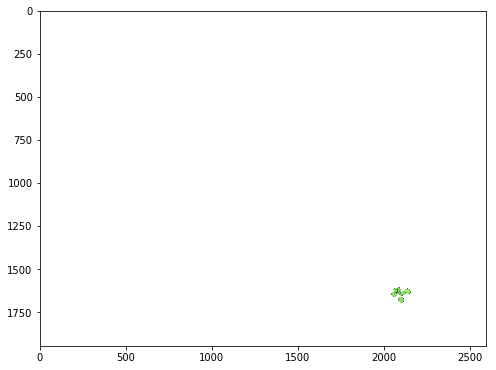

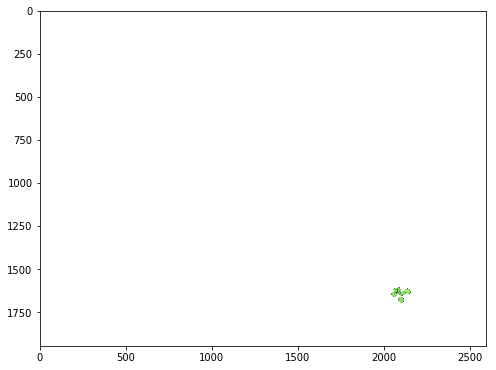

In [41]:
# Step 18: This function takes clustered contours and splits them into multiple images, 
# also does a check to make sure that the number of inputted filenames matches the number
# of clustered contours. If no filenames are given then the objects are just numbered

# Inputs:
#    device                  = device number.  Used to count steps in the pipeline
#    img                     = ideally a masked RGB image.
#    grouped_contour_indexes = output of cluster_contours, indexes of clusters of contours
#    contours                = contours to cluster, output of cluster_contours
#    outdir                  = output directory for split images
#    file                    = the name of the input image to use as a base name , output of filename from 
#                              read_image function
#    filenames               = input txt file with list of filenames in order from top to bottom left to right 
#                              (likely list of genotypes)
#    debug                   = None, print, or plot. Print = save to file, Plot = print to screen.
    
out = './figures/fig2.multiplant'
names = './examples/multi-plant-images/cam14.txt'
device, output_path = pcv.cluster_contour_splitimg(device=device, img=img1, grouped_contour_indexes=clusters_i, 
                                                   contours=contours, outdir=out, file=filename, filenames=None,
                                                   debug=debug)
# Some of these are used in Figure 3 (right)

In [38]:
print(output_path)

['./figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_0_p0.jpg', './figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_1_p1.jpg', './figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_2_p2.jpg', './figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_3_p3.jpg', './figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_4_p4.jpg', './figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_5_p5.jpg', './figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_6_p6.jpg', './figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_7_p7.jpg', './figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_8_p8.jpg', './figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_9_p9.jpg', './figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_10_p10.jpg', './figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_11_p11.jpg', './figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_12_p12.jpg', './figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_13_p13.jpg', './figures/fig2.multiplant/2016-09-27_1025_ch129-pos01_14_p14.jpg',

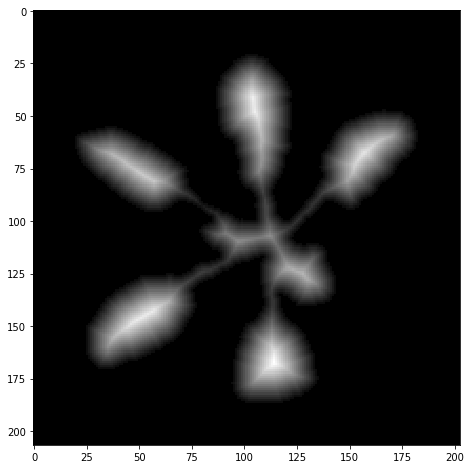

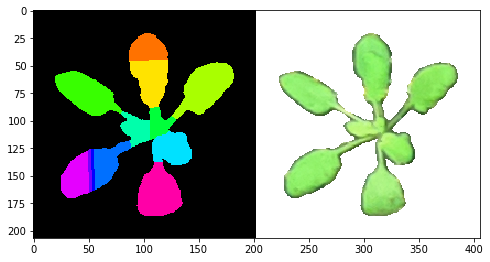

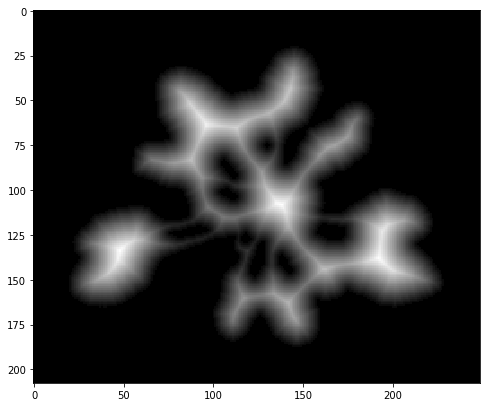

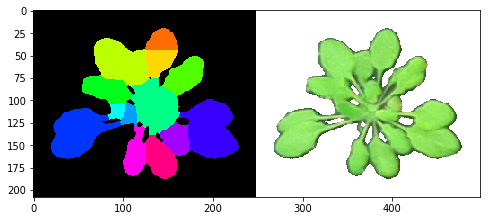

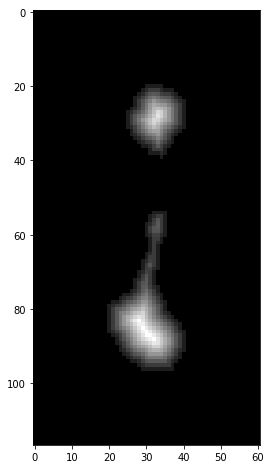

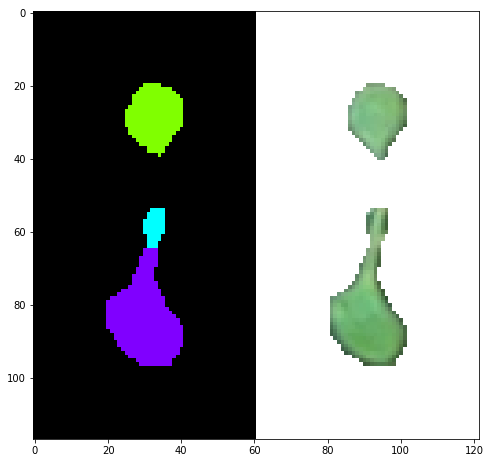

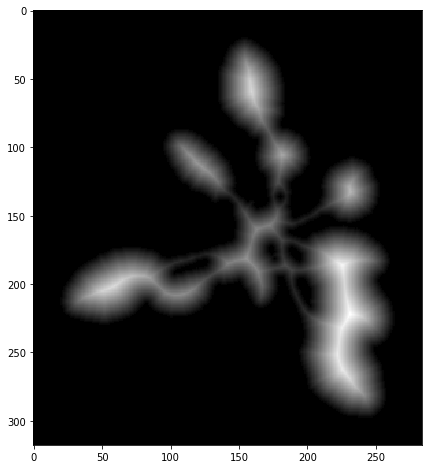

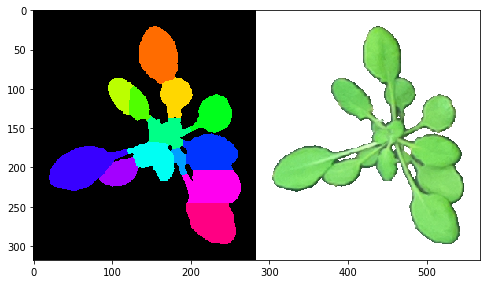

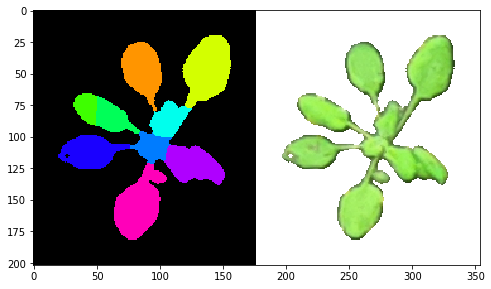

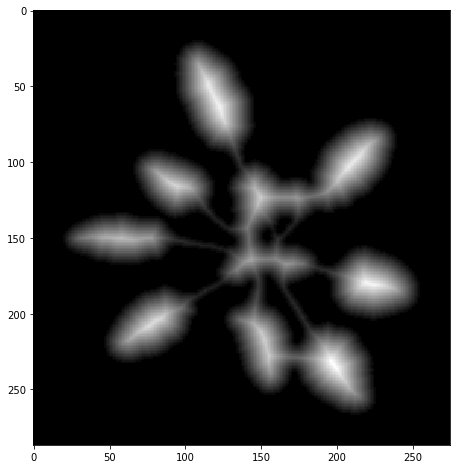

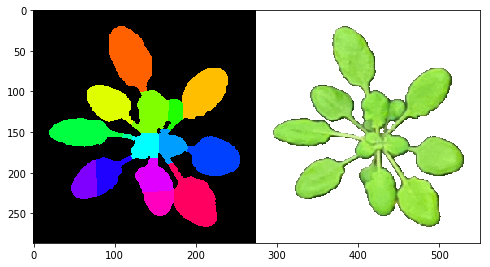

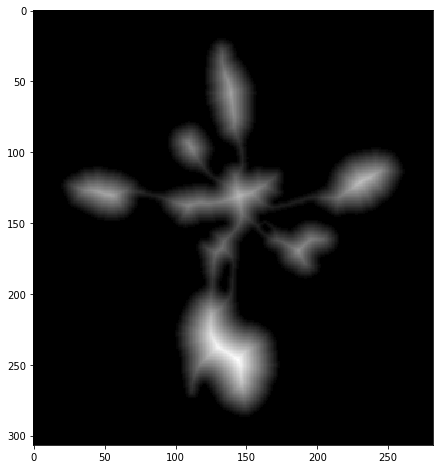

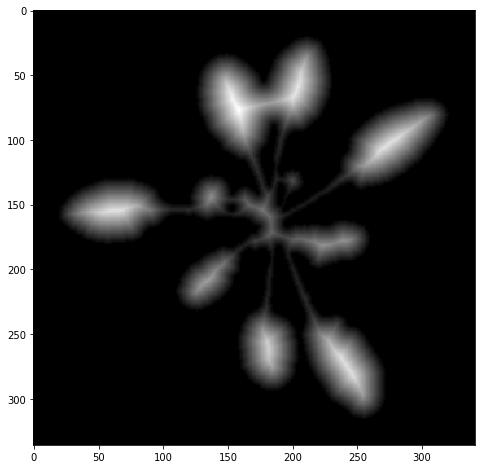

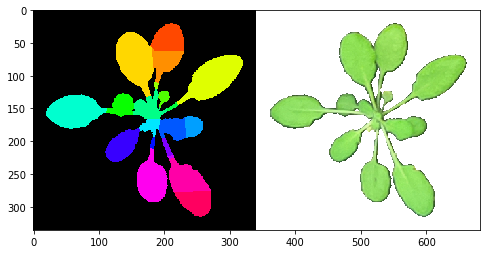

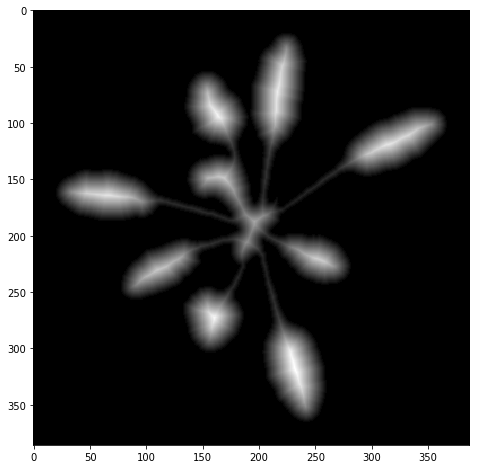

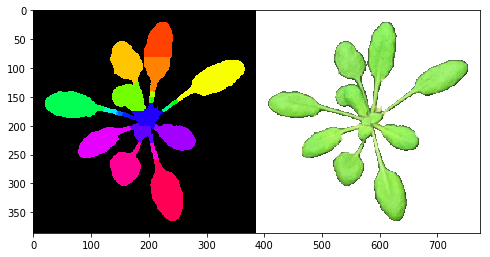

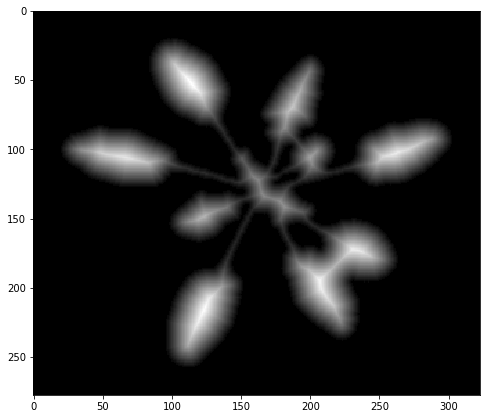

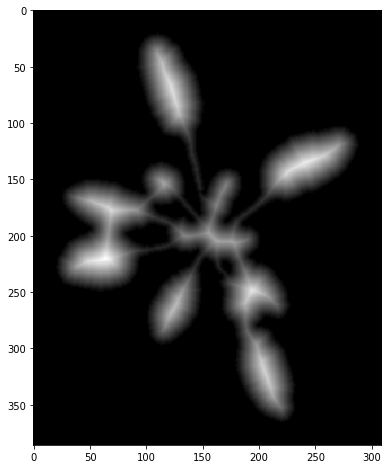

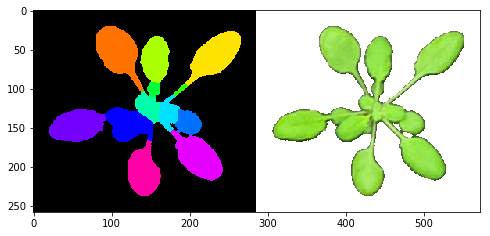

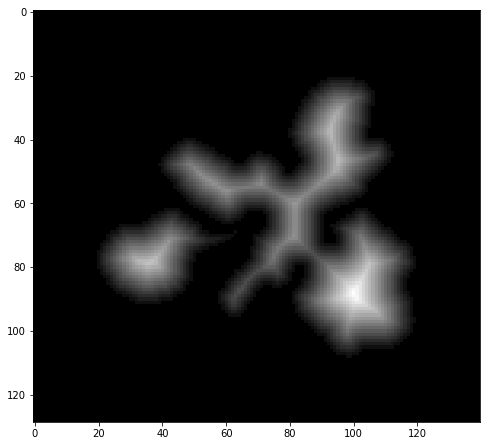

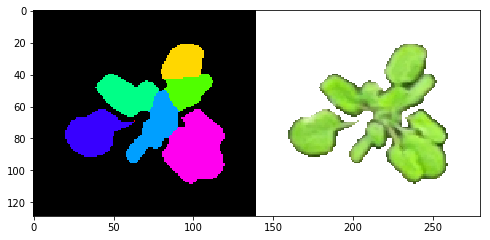

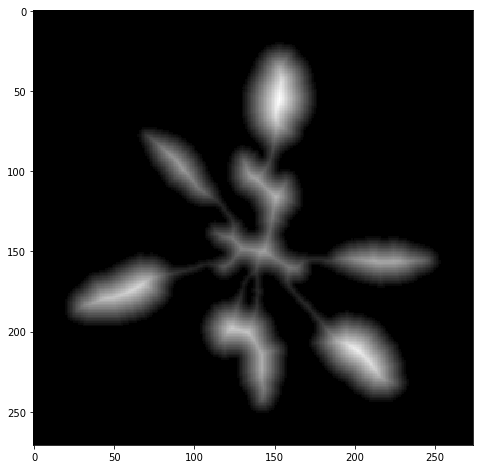

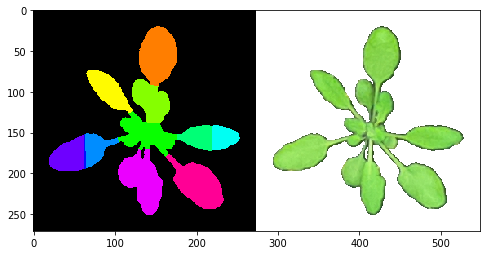

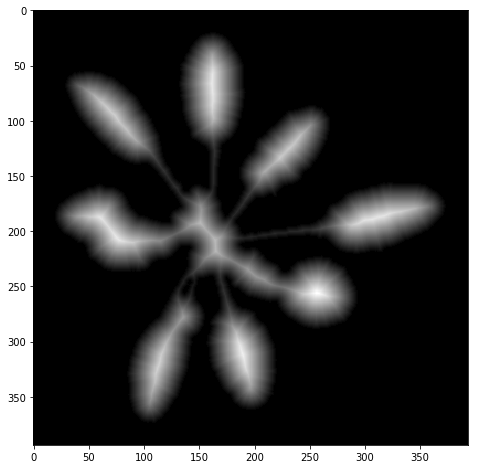

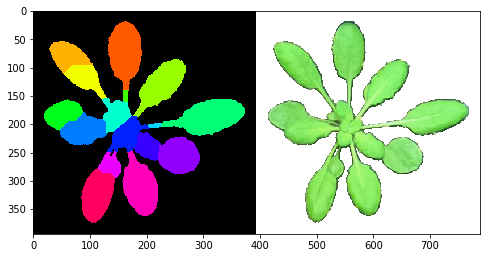

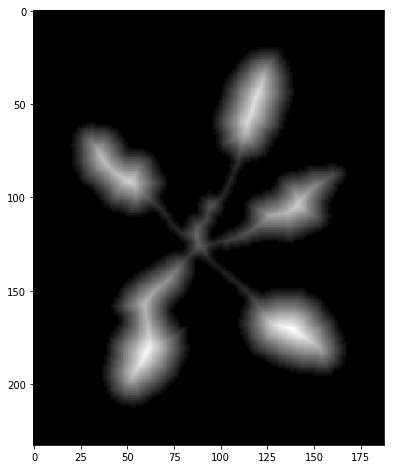

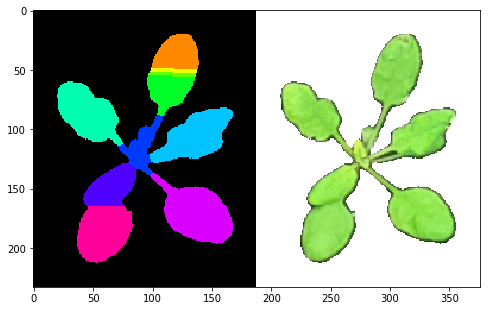

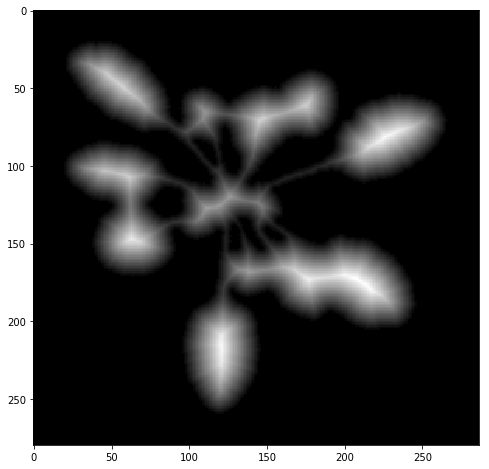

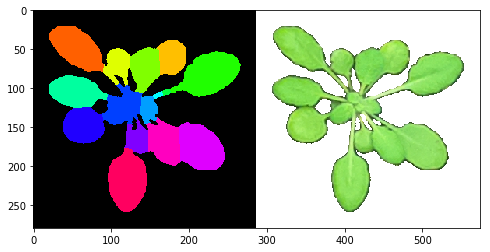

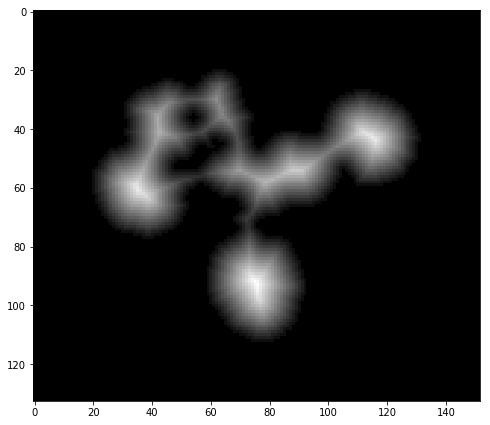

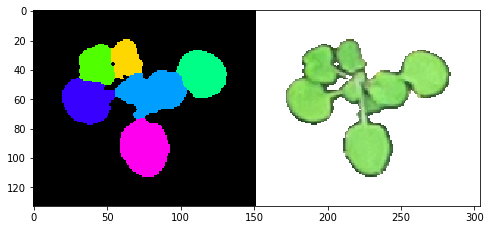

In [43]:
# Step 19: Now you have a folder of images with individual plants and you can process them (additional pipeline)
count_header=[]
count_data=[]

for x in output_path:
    cropimg, path2, filename2 = pcv.readimage(x)
    device, b1 = pcv.rgb2gray_lab(cropimg, 'b', device, None)
    device, masked_binary = pcv.binary_threshold(b1, 140, 255, 'light', device, None)
    device, id_objects, obj_hierarchy = pcv.find_objects(cropimg, masked_binary, device, None)
    device, obj, mask = pcv.object_composition(img1, id_objects, obj_hierarchy, device, None)
    device, crop_img = pcv.auto_crop(device, masked, obj, 20, 20, 'white', None)
    device, b2 = pcv.rgb2gray_lab(crop_img, 'b', device, None)
    device, crop_binary = pcv.binary_threshold(b2, 140, 255, 'light', device, None)
    cropname = str(path2) + str(filename2[:-4]) + "count.jpg"
    device, watershed_header, watershed_data, analysis_images = pcv.watershed_segmentation(device, crop_img, 
                                                                                           crop_binary, 10, cropname,
                                                                                           debug)
#     masked1, path, filename = pcv.readimage("./figures/shapes_shapes.jpg")
#     device, shape_header, shape_data, shape_img = pcv.analyze_object(masked1, 'imgname', obj, mask, device, debug,"./figures/shapes.jpg")
    if watershed_data is not None:
        count_data.append(watershed_data)
count_header.append(watershed_header)


In [44]:
print(count_data)

[('WATERSHED_DATA', 12), ('WATERSHED_DATA', 13), ('WATERSHED_DATA', 3), ('WATERSHED_DATA', 13), ('WATERSHED_DATA', 9), ('WATERSHED_DATA', 15), ('WATERSHED_DATA', 9), ('WATERSHED_DATA', 20), ('WATERSHED_DATA', 22), ('WATERSHED_DATA', 15), ('WATERSHED_DATA', 12), ('WATERSHED_DATA', 15), ('WATERSHED_DATA', 19), ('WATERSHED_DATA', 12), ('WATERSHED_DATA', 6), ('WATERSHED_DATA', 11), ('WATERSHED_DATA', 16), ('WATERSHED_DATA', 10), ('WATERSHED_DATA', 15), ('WATERSHED_DATA', 6)]
